<a href="https://colab.research.google.com/github/LennonLab/sporeAI/blob/main/cellSAM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CellSAM segmentation model

In [95]:
# have to run the below command for every new colab session
!pip install git+https://github.com/vanvalenlab/cellSAM.git

  Cloning https://github.com/vanvalenlab/cellSAM.git to /tmp/pip-req-build-45qvdtsa
  Running command git clone --filter=blob:none --quiet https://github.com/vanvalenlab/cellSAM.git /tmp/pip-req-build-45qvdtsa
  Resolved https://github.com/vanvalenlab/cellSAM.git to commit a392cdd199eebd11646cf6dd115a992af33f6365
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-install-kbt9hef_/segment-anything_a9ce16ea0ff449b3b63d3325996f2d51
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-install-kbt9hef_/segment-anything_a9ce16ea0ff449b3b63d3325996f2d51
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [111]:
import numpy as np
import cv2
import torch
from cellSAM import segment_cellular_image, get_model
from skimage import measure, morphology, io
from scipy.ndimage import find_objects
from pathlib import Path
from tqdm import tqdm
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches


class CellSeg:

    def __init__(self):
        self.img = None
        self.mask = None
        self.bounding_boxes = None
        self.centroids = None
        self.num_cells = None
        # load the cellSAM model
        # TODO: add functionality to get model directly from saved .pt instead of downloading everytime.
        get_model()

    def load_image(self, img_path):
        """Load an image from the specified path."""
        path = Path(img_path)
        if not path.exists():
            raise FileNotFoundError(f"The file {img_path} does not exist.")

        try:
            # img = cv2.imread(img_path)
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = io.imread(img_path)
            self.img = img
        except Exception as e:
            raise ValueError(f"Failed to load image from {img_path}: {str(e)}")

    def remove_distance_metric(self):
        """inpaint image to remove 10um artifact using inpainting"""
        mask = (self.img[:, :, 0] != self.img[:, :, 1]) | (self.img[:, :, 0] != self.img[:, :, 2])
        mask = mask.astype(np.uint8) * 255
        self.img = cv2.inpaint(self.img, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)

    def apply_gaussian_blur(self, kernel = (5,5), sigma = 1):
        """apply a gaussian blur to the image"""
        self.img = cv2.GaussianBlur(self.img, kernel, sigma)


    def segment_image(self, img, bounding_box_threshold = 0.2):
        """ Segment image using cellSAM"""
        available_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # see function at https://github.com/vanvalenlab/cellSAM/blob/master/cellSAM/model.py
        mask, _, bboxes = segment_cellular_image(
            img,
            device=str(available_device),
            normalize=True,
            fast=True,
            bbox_threshold=bounding_box_threshold
            )

        # convert predicted bounding boxes from tensor to np array
        boxes = bboxes[0].cpu().numpy()
        return mask, boxes


    def segment_quadrants(self, min_size = 700):
        """
        Segment the image by dividing it into quadrants, segmenting each separately, and then merging.

        Args:
            img (np.ndarray): Input image to be segmented.
            visualize_quadrants (bool): If True, stores quadrant results so that they can be visualized later.
            remove_small_obj (bool): If True, removes small objects after merging quadrants.
            min_size (int): Minimum size (in pixels) of objects to keep.

        Returns:
            tuple: (final_mask, final_boxes)
                - final_mask (np.ndarray): A labeled mask of the full image.
                - final_boxes (list): Bounding boxes of the detected objects after merging.
        """
        H, W = self.img.shape[:2]
        mid_h = H // 2
        mid_w = W // 2

        # Extract quadrants
        img_tl = self.img[0:mid_h, 0:mid_w]
        img_tr = self.img[0:mid_h, mid_w:W]
        img_bl = self.img[mid_h:H, 0:mid_w]
        img_br = self.img[mid_h:H, mid_w:W]

        # Segment each quadrant
        mask_tl, boxes_tl = self.segment_image(img_tl)
        mask_tr, boxes_tr = self.segment_image(img_tr)
        mask_bl, boxes_bl = self.segment_image(img_bl)
        mask_br, boxes_br = self.segment_image(img_br)

        # Store the quadrant results for visualization
        self.quadrant_results = {
            'top_left': (img_tl, mask_tl, boxes_tl),
            'top_right': (img_tr, mask_tr, boxes_tr),
            'bottom_left': (img_bl, mask_bl, boxes_bl),
            'bottom_right': (img_br, mask_br, boxes_br)
        }

        # Convert masks to integer type
        mask_tl = mask_tl.astype(np.int32)
        mask_tr = mask_tr.astype(np.int32)
        mask_bl = mask_bl.astype(np.int32)
        mask_br = mask_br.astype(np.int32)

        # Compute label offsets to ensure uniqueness across quadrants
        max_label_tl = mask_tl.max()
        mask_tr[mask_tr > 0] += max_label_tl
        max_label_tr = mask_tr.max() if mask_tr.max() > 0 else max_label_tl
        mask_bl[mask_bl > 0] += max_label_tr
        max_label_bl = mask_bl.max() if mask_bl.max() > 0 else max_label_tr
        mask_br[mask_br > 0] += max_label_bl

        # Recombine masks into one big mask
        final_mask = np.zeros((H, W), dtype=np.int32)
        final_mask[0:mid_h, 0:mid_w] = mask_tl
        final_mask[0:mid_h, mid_w:W] = mask_tr
        final_mask[mid_h:H, 0:mid_w] = mask_bl
        final_mask[mid_h:H, mid_w:W] = mask_br

        # Handle objects that cross quadrant boundaries
        final_mask, _ = measure.label(final_mask, background=0, return_num=True)

        ### Remove small objects and get cell properties
        # get properties of each labeled region
        props = measure.regionprops(final_mask)

        centers = []
        bboxes = []

        for prop in props:
            if prop.area < min_size:
                # set small objects pixels to 0 to remove it
                final_mask[final_mask == prop.label] = 0
            else:
                # extract cell centers and bounding boxes
                centers.append(prop.centroid) # (x,y) coordinates
                bboxes.append(prop.bbox) # (y_min, x_min, y_max, x_max)

        # Convert the bboxes to the format [min_x, min_y, max_x, max_y]
        boxes = [[float(min_x), float(min_y), float(max_x), float(max_y)] for (min_y, min_x, max_y, max_x) in bboxes]

        final_mask, num_cells = measure.label(final_mask, background=0, return_num=True)

        self.mask = final_mask
        self.num_cells = num_cells
        self.bounding_boxes = boxes
        self.centroids = centers


    def visualize(self):
        """Visualize segmentation results"""
        if self.mask is not None:
          fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

          # Original image
          ax1.imshow(self.img)
          ax1.set_title("Original Image")
          ax1.axis('off')

          # Mask overlay
          ax2.imshow(self.img)
          colored_mask = np.ma.masked_where(self.mask == 0, self.mask)
          ax2.imshow(colored_mask, cmap='hsv', alpha=0.5)
          ax2.set_title("Segmentation Mask")
          ax2.axis('off')

          # Bounding boxes
          ax3.imshow(self.img)
          for box in self.bounding_boxes:
              x_min, y_min, x_max, y_max = box
              width = x_max - x_min
              height = y_max - y_min
              rect = patches.Rectangle(
                  (x_min, y_min), width, height,
                  linewidth=1, edgecolor='r', facecolor='none'
              )
              ax3.add_patch(rect)
          ax3.set_title("Bounding Boxes")
          ax3.axis('off')

          plt.tight_layout()
          plt.show()

        else:
          plt.axis('off')
          plt.imshow(self.img)
          plt.show()

In [101]:
dirpath = "/content/drive/MyDrive/LennonLab"
imgname = "20240917_delta6_100x_2.tif"
imgpath = os.path.join(dirpath, imgname)

In [102]:
test = CellSeg()

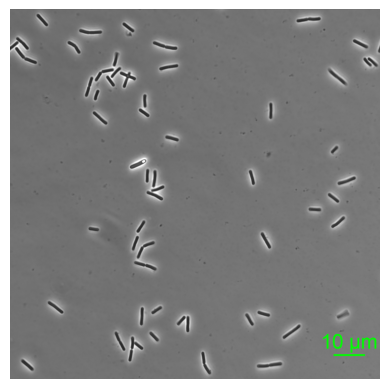

In [103]:
test.load_image(imgpath)
test.visualize()

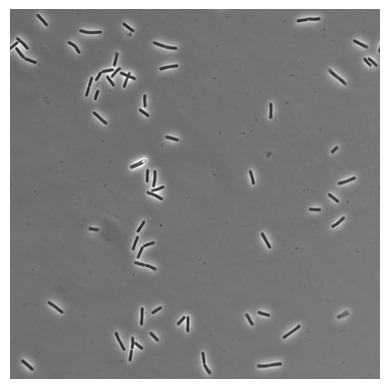

In [104]:
test.remove_distance_metric()
test.apply_gaussian_blur()
test.visualize()

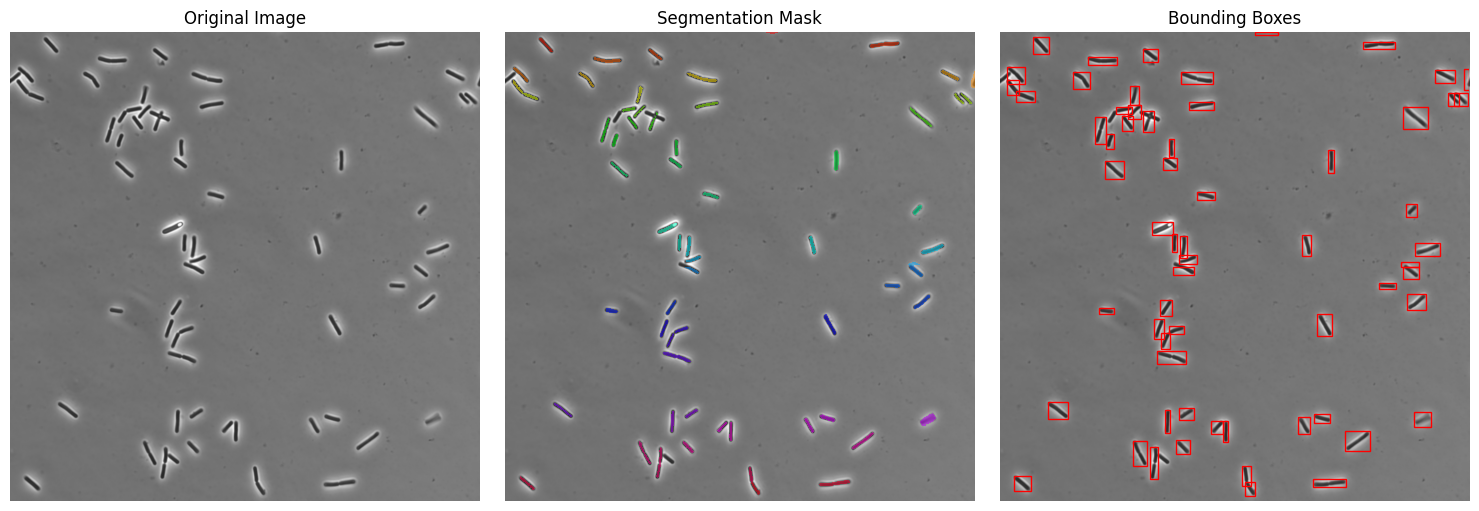

In [110]:
test.segment_quadrants(min_size=700)
test.visualize()

In [ ]:
test.num_cells

307

Processing image: /content/drive/MyDrive/LennonLab/20240917_delta6_100x_2.tif


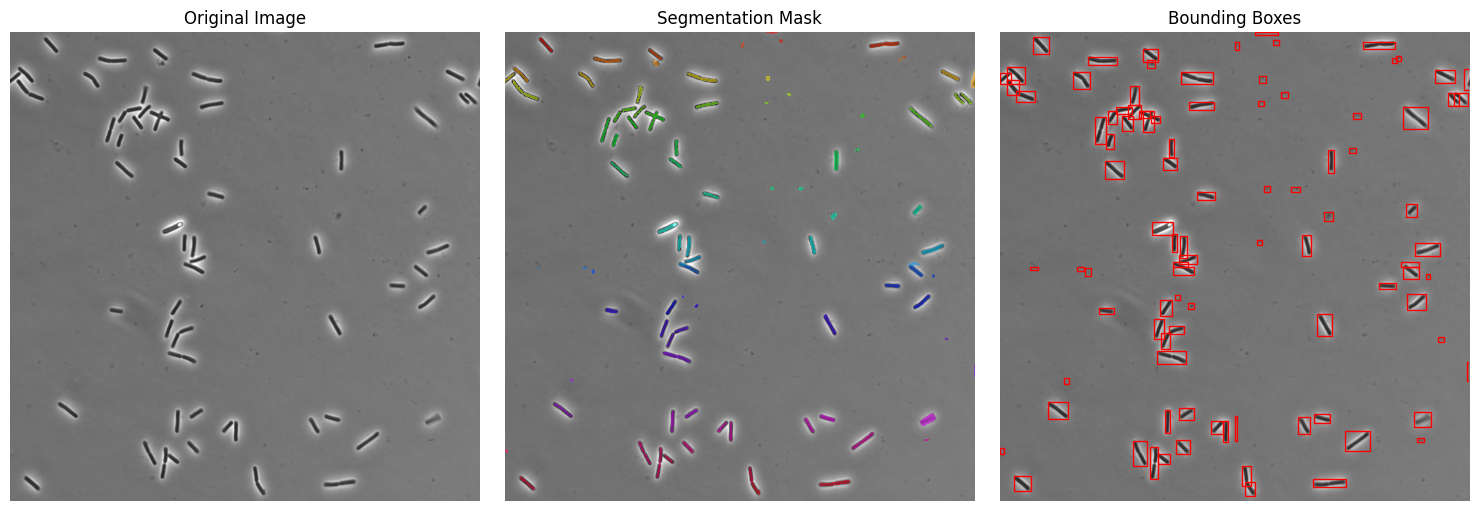

Number of cells: 95
Processing image: /content/drive/MyDrive/LennonLab/20240917_delta6_100x_3.tif


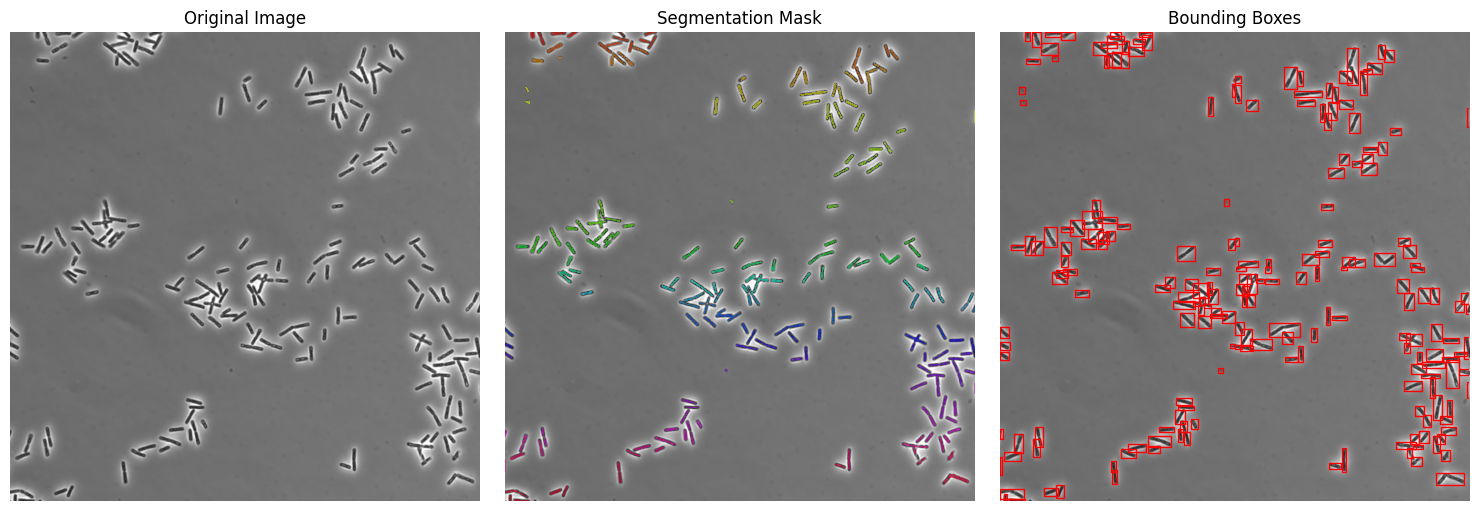

Number of cells: 207
Processing image: /content/drive/MyDrive/LennonLab/20240917_delta6_6.tif


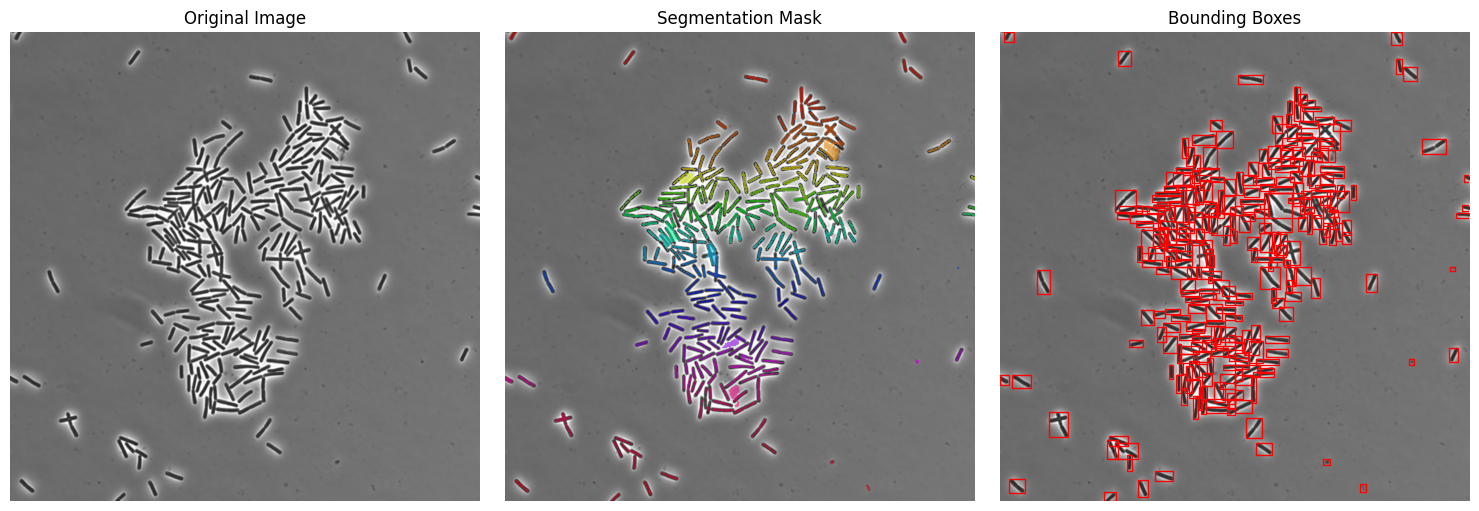

Number of cells: 307
Processing image: /content/drive/MyDrive/LennonLab/20240917_delta6_100x_4.tif


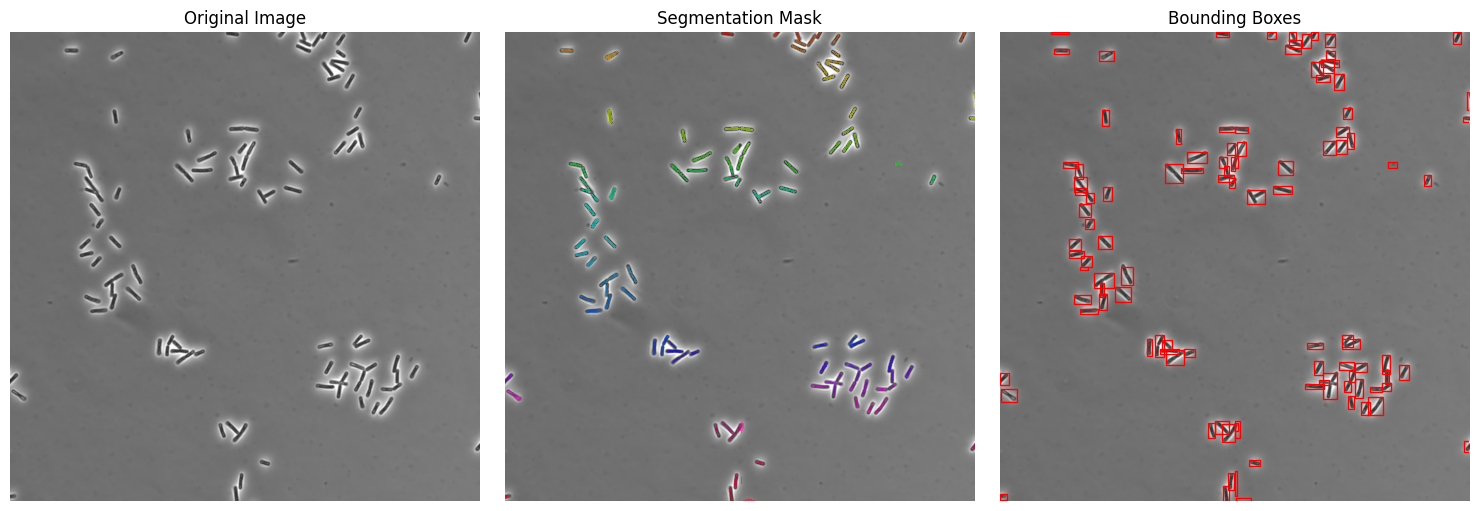

Number of cells: 105
Processing image: /content/drive/MyDrive/LennonLab/20240917_delta6_5.tif


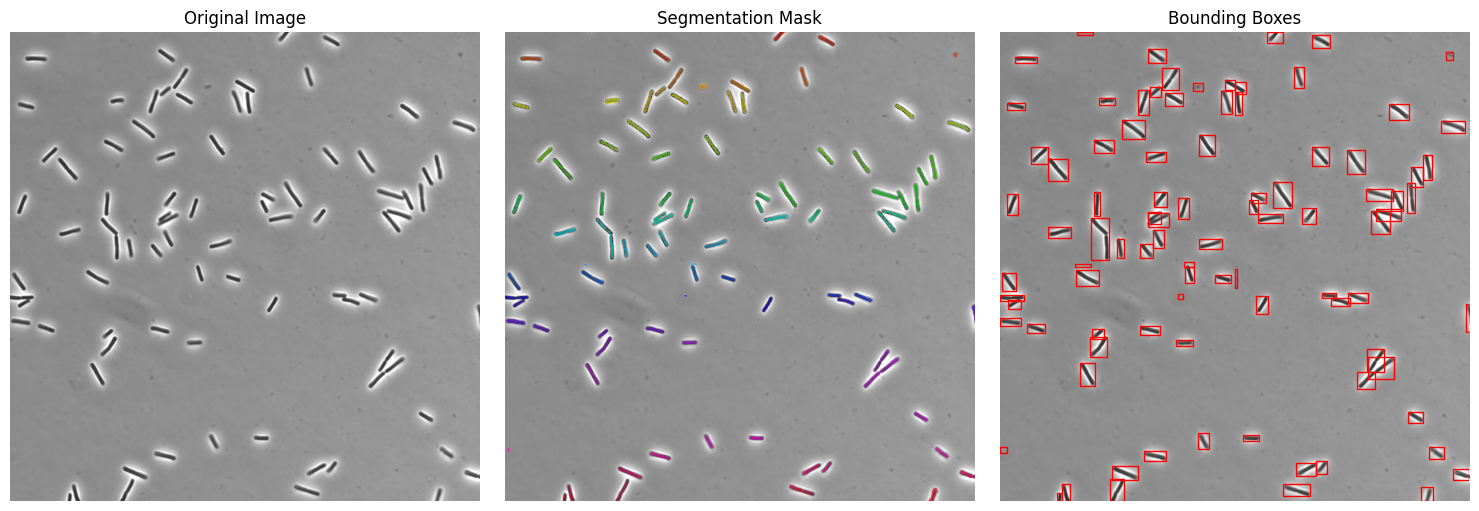

Number of cells: 92
Processing image: /content/drive/MyDrive/LennonLab/20240917_delta6_100x_1.tif


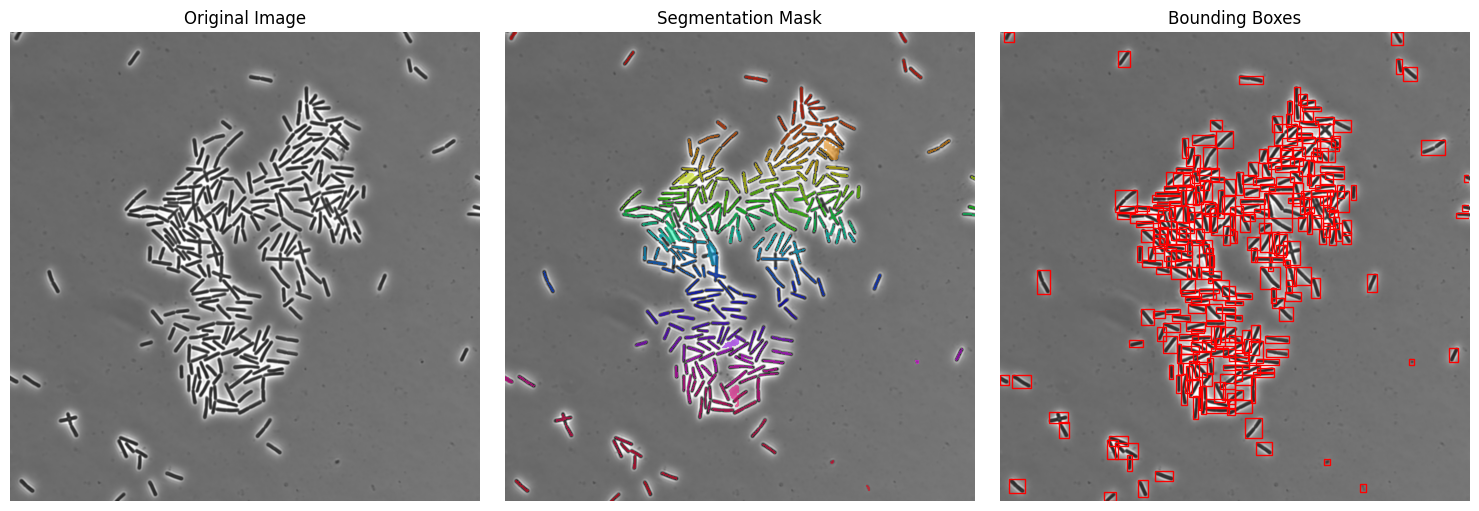

Number of cells: 307


In [97]:
dirpath = "/content/drive/MyDrive/LennonLab"


# List all files in the directory
all_files = os.listdir(dirpath)

# Filter to only include image files (e.g., .tif files)
image_files = [file for file in all_files if file.endswith('.tif')]

# Loop through each image file in the directory
for imgname in image_files:
    imgpath = os.path.join(dirpath, imgname)
    print(f"Processing image: {imgpath}")
    # Add your image processing logic here

    seg = CellSeg()
    seg.load_image(imgpath)
    seg.remove_distance_metric()
    seg.apply_gaussian_blur()
    seg.segment_quadrants()
    seg.visualize()
    print(f"Number of cells: {seg.num_cells}")